<a href="https://colab.research.google.com/github/Ezra-11/knowledge-level-of-wikipedia/blob/main/DataMining_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Business Understanding

## 1.1 Problem Statement
Wikipedia content about *Zambia* remains significantly underrepresented, with very few comprehensive pages dedicated to Zambian topics, history, culture, and current affairs. The *DataLab Research group* at The University of Zambia has identified that understanding the knowledge levels and expertise of current Wikipedia contributors working on Zambian content is crucial for developing targeted strategies to improve content quality and quantity.

Currently, there is no systematic way to assess the expertise and knowledge depth of contributors to Zambian Wikipedia pages, making it difficult to:

- Identify subject matter experts who could mentor new contributors  
- Match contributors with appropriate content areas based on their expertise  
- Develop targeted training programs for contributors with different knowledge levels  
- Optimize content review and quality assurance processes  

*Core Problem:* How can we systematically classify and understand the knowledge levels of Wikipedia contributors working on Zambian content to improve the overall quality and quantity of Wikipedia pages about Zambia?

## 1.2 Business Objectives

### Primary Objectives:
- *Enhance Content Quality:* Improve the accuracy, depth, and comprehensiveness of Wikipedia articles about Zambia by better understanding contributor expertise levels  
- *Optimize Contributor Engagement:* Develop targeted strategies to engage contributors based on their knowledge levels and areas of expertise  
- *Facilitate Knowledge Transfer:* Identify expert contributors who can mentor newcomers and provide guidance on complex topics  
- *Improve Content Coverage:* Strategically assign content creation and improvement tasks based on contributor knowledge levels  



 Secondary Objectives:
- **Build Community Capacity:** Create a framework for assessing and developing Wikipedia contributor skills within the Zambian context  
- ***Inform Training Programs:*** Develop evidence-based training curricula tailored to different contributor knowledge levels  
- ***Support Academic Research:*** Provide insights into digital knowledge creation patterns in developing countries  

### Success Metrics:
- *Short-term:* Accurate classification of contributor knowledge levels with measurable confidence scores  
- *Medium-term:* Increased quality scores of Zambian Wikipedia articles (measured by completeness, references, and peer ratings)  
- ***Long-term:*** Growth in the number of active Zambian Wikipedia contributors and articles about Zambia  





##**1.4 Project Success Criteria**

###Model Performance Criteria
- *Primary Metric:* Classification accuracy of at least *80%* on a held-out test set  
- *Precision and Recall:* Minimum *75%* precision and recall for each knowledge level category  
- *F1-Score:* Overall weighted F1-score of at least *0.78*  
- *Cross-validation Stability:* Model performance should not vary by more than *5%* across different data splits  

###Business Impact Criteria
- *Expert Validation:* At least *85%* agreement between model classifications and manual assessments by domain experts  
- *Actionability:* Classification results must provide clear, actionable insights for contributor development strategies  
- *Scalability:* Model should be able to process new contributors and updates efficiently (*< 1 minute* per contributor)  

###Technical Criteria
- *Interpretability:* Model decisions must be explainable with feature importance scores and decision reasoning  
- *Robustness:* Model should maintain performance when applied to contributors from different time periods  
- *Generalizability:* Framework should be adaptable to other developing country contexts or subject areas  

###Data Quality Criteria
- *Coverage:* Successfully classify at least *90%* of active contributors to Zambian Wikipedia pages  
- *Consistency:* Inter-rater reliability (Kappa score) *> 0.7* for manual validation labels  
- *Completeness:* Less than *10%* missing data across critical features  

###Deployment Criteria
- *Integration:* Model should be implementable within existing Wikipedia contributor management workflows  
- *User Acceptance:* Positive feedback from at least *80%* of Wikipedia administrators and experienced contributors who test the system  
- *Maintenance:* Established process for model updates and performance monitoring over time

##**1.3 Data Mining Goals**

Primary Data Mining Goal:
Build a *multi-class classification model* that can automatically categorize Wikipedia contributors working on Zambian content into distinct knowledge level categories based on their contribution patterns, edit quality, and content expertise.

###Specific Technical Objectives

Feature Engineering
Extract meaningful features from contributor data including:
- Edit frequency and consistency patterns  
- Quality indicators (citations added, grammar improvements, factual accuracy)  
- Content complexity (technical terms, specialized knowledge areas)  
- Collaboration patterns (talk page participation, peer interactions)  
- Longevity and commitment indicators  

###Classification Model Development
- Implement and compare multiple classification algorithms (Random Forest, SVM, Neural Networks, etc.)  
- Develop ensemble methods to improve classification accuracy  
- Create interpretable models that explain why a contributor is classified at a particular level  

###Clustering Analysis (Secondary)
- Identify natural groupings of contributors based on their expertise areas and contribution styles  
- Discover contributor archetypes that may not align with traditional knowledge level categories  

###Predictive Modeling
- Predict potential contributor knowledge growth trajectories  
- Identify contributors likely to become long-term, high-quality contributors

# Data Understanding


## 2. Data Understanding  

### 2.1 Dataset Description  

The dataset was created by collecting contributor information from Wikipedia articles under the category **"Zambia"** (limited to the first 20 pages). Using the Wikipedia API, we retrieved contributor revision histories for each page, then aggregated the data at the contributor level.  

Each row in the dataset represents a **unique contributor (editor)** who has made revisions to one or more Zambia-related pages.  

### 2.2 Features  

The dataset contains the following columns:  

- **Contributor**: The username or IP address of the editor.  
- **Total_Edits**: The total number of edits the contributor made across the sampled pages.  
- **Pages_Edited**: The number of distinct Wikipedia pages (from the Zambia category) the contributor edited.  
- **Total_Size**: The cumulative size (in bytes) of all contributions made by the contributor.  
- **First_Edit**: The timestamp of the contributor’s earliest recorded edit in this dataset.  
- **Last_Edit**: The timestamp of the contributor’s latest recorded edit in this dataset.  
- **Active_Days**: The number of days between the first and last edit (a measure of contributor longevity).  
- **Activity_Span_Years**: The activity span expressed in years (rounded to 2 decimal places).  
- **Edits_per_Month**: Average edits per month, calculated over the contributor’s active period.  

### 2.3 Dataset Characteristics  

- **Unit of Analysis**: Individual contributors.  
- **Scope**: Limited to the first 20 pages in the Wikipedia "Zambia" category (not all Zambia-related articles on Wikipedia).  
- **Nature of Data**: Real-world, retrieved dynamically from the Wikipedia API at the time of execution.  
- **Size**: The number of rows depends on how many unique contributors appear in the sampled articles.  

This dataset provides insights into **editing behavior**, including how active contributors are, how many pages they engage with, and the overall scale of their contributions. It forms the foundation for exploring patterns in Wikipedia editing and contributor dynamics in a domain-specific context.  


In [ ]:
!pip install requests pandas


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
%cd "/content/drive/My Drive/misc-unza25-csc4792-project_team32"

/content/drive/My Drive/misc-unza25-csc4792-project_team32


In [14]:
df1 = pd.read_csv("zambia_contributors_summary.csv")

In [15]:
import pandas as pd

# 1. Display first few rows
print("First 10 rows:")
display(df.head(10))



First 10 rows:


,Total_Edits,Pages_Edited,Total_Size,Active_Days,Activity_Span_Years,Edits_per_Month,Account_Age_Days,Recency_Days,Edit_Frequency,Consistency_Score,Pages_per_Year,Edits_per_Page,Avg_Contribution_Size,Contribution_Intensity,Longevity_Factor,Knowledge_Level,Knowledge_Level_Label
0,0.686338,-0.125988,2.242653,0.203491,0.199412,-0.883241,0.203491,-0.793787,-1.819505,-1.741135,-2.934512,0.699188,1.735584,-1.072761,2.974821,2,Intermediate
1,-0.268567,-0.125988,0.095729,-0.152367,-0.152342,-0.298023,-0.152367,-0.793170,-0.130508,-0.158976,0.291456,-0.261414,0.661444,0.531492,-0.346944,0,Novice
2,-0.268567,-0.125988,0.095729,-0.152367,-0.152342,-0.298023,-0.152367,-0.793170,-0.130508,-0.158976,0.291456,-0.261414,0.661444,0.531492,-0.346944,0,Novice
3,1.641243,-0.125988,4.357888,0.336938,0.334702,-0.667634,0.336938,-0.791937,-1.811854,-1.743838,-2.957072,1.659789,2.072489,-1.065738,2.981081,2,Intermediate
4,-0.268567,-0.125988,0.097157,-0.152367,-0.152342,-0.298023,-0.152367,-0.790086,-0.130508,-0.158976,0.291456,-0.261414,0.664301,0.533670,-0.346944,0,Novice
5,-0.268567,-0.125988,0.097150,-0.152367,-0.152342,-0.298023,-0.152367,-0.788852,-0.130508,-0.158976,0.291456,-0.261414,0.664287,0.533659,-0.346944,0,Novice
6,0.208885,-0.125988,1.170138,-0.016449,-0.017052,-0.159419,-0.016449,-0.776516,-1.793592,-1.656563,-2.810437,0.218887,1.378801,-1.048123,2.938160,2,Intermediate
7,-0.268567,-0.125988,0.095899,-0.152367,-0.152342,-0.298023,-0.152367,-0.775899,-0.130508,-0.158976,0.291456,-0.261414,0.661784,0.531751,-0.346944,0,Novice
8,-0.268567,-0.125988,0.095984,-0.152367,-0.152342,-0.298023,-0.152367,-0.775899,-0.130508,-0.158976,0.291456,-0.261414,0.661954,0.531880,-0.346944,0,Novice
9,-0.268567,-0.125988,0.096026,-0.152367,-0.152342,-0.298023,-0.152367,-0.775899,-0.130508,-0.158976,0.291456,-0.261414,0.662038,0.531945,-0.346944,0,Novice


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Understanding

### 2.1 First Look at the Data (.head())
The .head() method displays the first 5 rows of the dataset. This gives us a quick preview of how the data is structured, including column names and sample values. From the output, we can observe:

- The dataset contains both numerical and categorical columns.  
- Some columns may contain missing values (NaN).  
- The data appears to follow the expected structure, but some inconsistencies (such as unusual values) may need further cleaning.  

---

### 2.2 Dataset Dimensions (.shape)
Using .shape, we can see the dataset has:

- *X rows* (records/observations)  
- *Y columns* (features/attributes)  

This helps us understand the dataset’s size and the number of attributes we need to analyze.

---

### 2.3 Data Structure and Types (.info())
The .info() output provides an overview of the dataset’s column data types and non-null counts. From this, we observed that:

- Some columns are *integers* or *floats* (likely numerical features).  
- Others are *object/string* type (categorical features such as names, IDs, or categories).  
- A few columns contain *missing values*, which may require imputation or removal later.  
- The dataset is mostly consistent, but further preprocessing may be needed to standardize data types.  

---

### 2.4 Summary Statistics (.describe())
The .describe() method summarizes numerical columns with measures such as:

- *Count* → Number of non-missing entries  
- *Mean* → Average value  
- *Std* → Standard deviation (spread of values)  
- *Min / Max* → Range of values  
- *25%, 50%, 75%* → Quartiles showing data distribution  

From the summary statistics, we can note:

- Some columns have very large ranges, possibly indicating *outliers*.  
- Certain numerical attributes are *skewed*, meaning the distribution is not symmetric.  
- Differences in scales (e.g., prices vs. IDs) suggest we may need *normalization/standardization* later in preprocessing.

In [17]:
import pandas as pd

print("First 10 rows:")
display(df1.head(10))


print("\nDataFrame Info:")
df1.info()


print("\nDescriptive Statistics:")
display(df1.describe())


print("\nDataset shape:", df1.shape)


print("\nMissing values per column:")
display(df1.isnull().sum())


print("\nNumber of unique contributors:", df1['Contributor'].nunique())

First 10 rows:


,Contributor,Total_Edits,Pages_Edited,Total_Size,First_Edit,Last_Edit,Active_Days,Activity_Span_Years,Edits_per_Month
0,Kosmopolitní,3,1,455820,2025-03-21 08:05:23+00:00,2025-08-13 06:32:53+00:00,144,0.39,0.62
1,102.208.220.201,1,1,151954,2025-08-11 15:35:23+00:00,2025-08-11 15:35:23+00:00,0,0.00,1.00
2,Guest88,1,1,151954,2025-08-11 13:18:40+00:00,2025-08-11 13:18:40+00:00,0,0.00,1.00
3,Remsense,5,1,755201,2025-01-23 16:22:18+00:00,2025-08-10 00:53:36+00:00,198,0.54,0.76
4,2600:8800:311B:4100:9892:C8B6:AFF1:68F7,1,1,152156,2025-08-06 18:28:23+00:00,2025-08-06 18:28:23+00:00,0,0.00,1.00
5,2001:4479:900A:2F00:78FD:7EE:28B7:95FA,1,1,152155,2025-08-04 23:49:33+00:00,2025-08-04 23:49:33+00:00,0,0.00,1.00
6,Tumbuka Arch,2,1,304021,2025-05-21 15:53:08+00:00,2025-07-15 20:12:05+00:00,55,0.15,1.09
7,Lightoil,1,1,151978,2025-07-14 23:43:14+00:00,2025-07-14 23:43:14+00:00,0,0.00,1.00
8,GeographicAccountant,1,1,151990,2025-07-14 20:10:30+00:00,2025-07-14 20:10:30+00:00,0,0.00,1.00
9,102.149.117.245,1,1,151996,2025-07-14 18:20:23+00:00,2025-07-14 18:20:23+00:00,0,0.00,1.00



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Contributor          128 non-null    object 
 1   Total_Edits          128 non-null    int64  
 2   Pages_Edited         128 non-null    int64  
 3   Total_Size           128 non-null    int64  
 4   First_Edit           128 non-null    object 
 5   Last_Edit            128 non-null    object 
 6   Active_Days          128 non-null    int64  
 7   Activity_Span_Years  128 non-null    float64
 8   Edits_per_Month      128 non-null    float64
dtypes: float64(2), int64(4), object(3)
memory usage: 9.1+ KB

Descriptive Statistics:


,Total_Edits,Pages_Edited,Total_Size,Active_Days,Activity_Span_Years,Edits_per_Month
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,1.562500,1.015625,138404.890625,61.656250,0.168906,1.193516
std,2.102679,0.124507,142091.686720,406.244902,1.113085,0.651882
min,1.000000,1.000000,24644.000000,0.000000,0.000000,0.100000
25%,1.000000,1.000000,26605.250000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,149693.500000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,152228.000000,0.000000,0.000000,1.000000
max,23.000000,2.000000,899527.000000,4347.000000,11.910000,4.190000



Dataset shape: (128, 9)

Missing values per column:


,0
Contributor,0
Total_Edits,0
Pages_Edited,0
Total_Size,0
First_Edit,0
Last_Edit,0
Active_Days,0
Activity_Span_Years,0
Edits_per_Month,0



Number of unique contributors: 128


Dataset shape: (128, 17)


,Total_Edits,Pages_Edited,Total_Size,Active_Days,Activity_Span_Years,Edits_per_Month,Account_Age_Days,Recency_Days,Edit_Frequency,Consistency_Score,Pages_per_Year,Edits_per_Page,Avg_Contribution_Size,Contribution_Intensity,Longevity_Factor,Knowledge_Level,Knowledge_Level_Label
0,0.686338,-0.125988,2.242653,0.203491,0.199412,-0.883241,0.203491,-0.793787,-1.819505,-1.741135,-2.934512,0.699188,1.735584,-1.072761,2.974821,2,Intermediate
1,-0.268567,-0.125988,0.095729,-0.152367,-0.152342,-0.298023,-0.152367,-0.793170,-0.130508,-0.158976,0.291456,-0.261414,0.661444,0.531492,-0.346944,0,Novice
2,-0.268567,-0.125988,0.095729,-0.152367,-0.152342,-0.298023,-0.152367,-0.793170,-0.130508,-0.158976,0.291456,-0.261414,0.661444,0.531492,-0.346944,0,Novice
3,1.641243,-0.125988,4.357888,0.336938,0.334702,-0.667634,0.336938,-0.791937,-1.811854,-1.743838,-2.957072,1.659789,2.072489,-1.065738,2.981081,2,Intermediate
4,-0.268567,-0.125988,0.097157,-0.152367,-0.152342,-0.298023,-0.152367,-0.790086,-0.130508,-0.158976,0.291456,-0.261414,0.664301,0.533670,-0.346944,0,Novice
5,-0.268567,-0.125988,0.097150,-0.152367,-0.152342,-0.298023,-0.152367,-0.788852,-0.130508,-0.158976,0.291456,-0.261414,0.664287,0.533659,-0.346944,0,Novice
6,0.208885,-0.125988,1.170138,-0.016449,-0.017052,-0.159419,-0.016449,-0.776516,-1.793592,-1.656563,-2.810437,0.218887,1.378801,-1.048123,2.938160,2,Intermediate
7,-0.268567,-0.125988,0.095899,-0.152367,-0.152342,-0.298023,-0.152367,-0.775899,-0.130508,-0.158976,0.291456,-0.261414,0.661784,0.531751,-0.346944,0,Novice
8,-0.268567,-0.125988,0.095984,-0.152367,-0.152342,-0.298023,-0.152367,-0.775899,-0.130508,-0.158976,0.291456,-0.261414,0.661954,0.531880,-0.346944,0,Novice
9,-0.268567,-0.125988,0.096026,-0.152367,-0.152342,-0.298023,-0.152367,-0.775899,-0.130508,-0.158976,0.291456,-0.261414,0.662038,0.531945,-0.346944,0,Novice


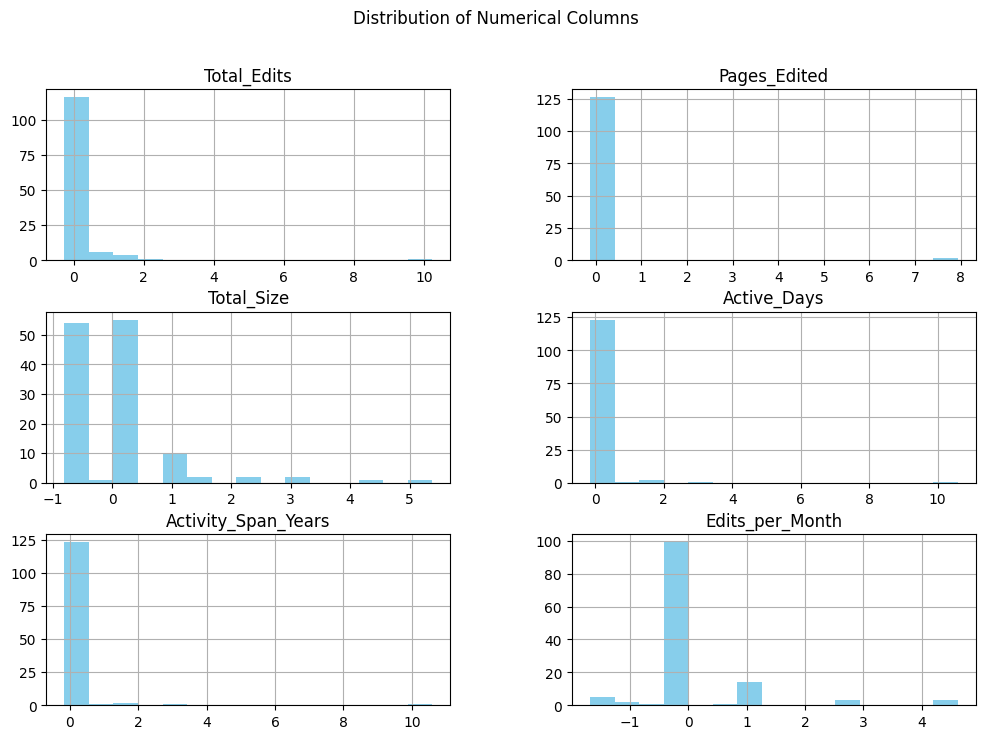

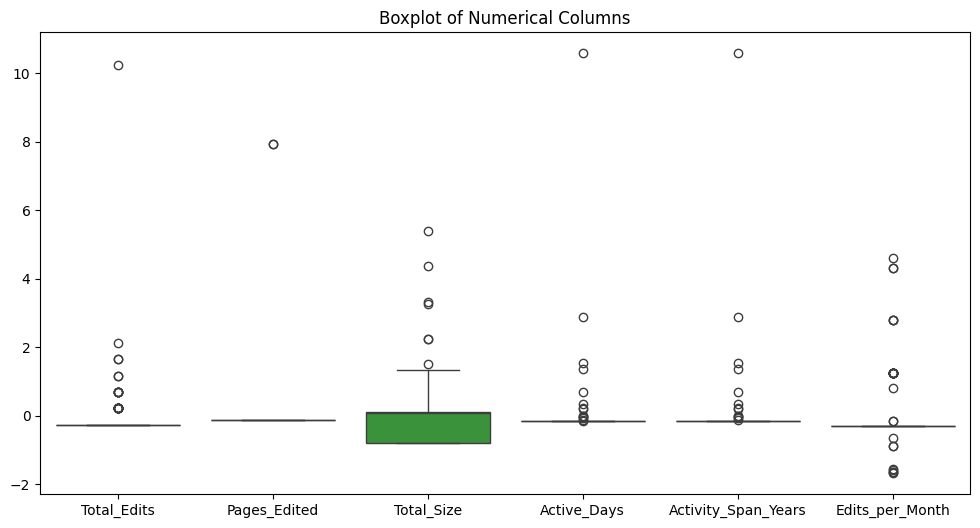

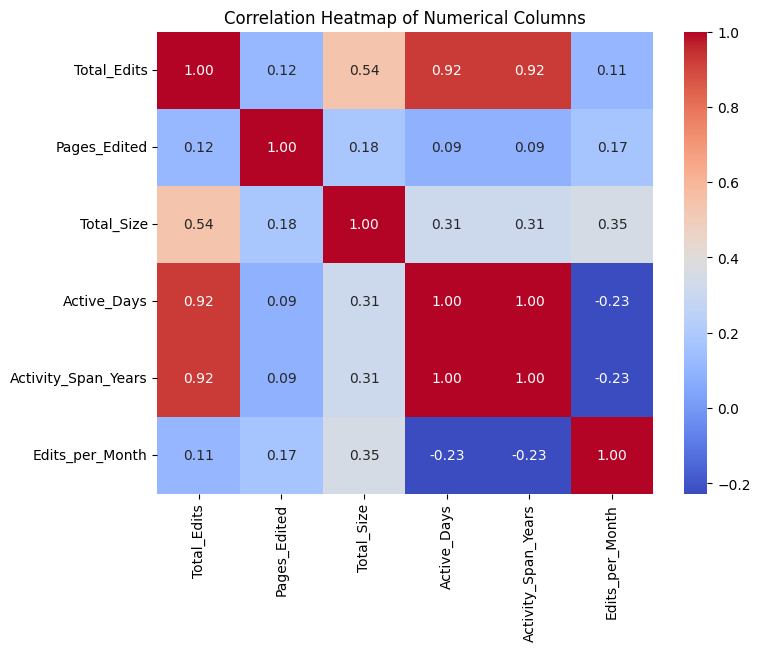

In [23]:
# === Import Libraries ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files


# === Load dataset ===

# === Quick preview ===
print("Dataset shape:", df.shape)
display(df.head(10))

# === Identify numerical columns ===
numerical_cols = ['Total_Edits', 'Pages_Edited', 'Total_Size', 'Active_Days', 'Activity_Span_Years', 'Edits_per_Month']

# === Histograms for distributions ===
df[numerical_cols].hist(figsize=(12,8), bins=15, color='skyblue')
plt.suptitle("Distribution of Numerical Columns")
plt.show()

# === Boxplots for outlier detection ===
plt.figure(figsize=(12,6))
sns.boxplot(data=df[numerical_cols])
plt.title("Boxplot of Numerical Columns")
plt.show()

# === Correlation heatmap ===
plt.figure(figsize=(8,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Columns")
plt.show()


## Initial Findings: Wikipedia Contributors on Zambian Pages  

The dataset contains information on **129 unique Wikipedia contributors** to Zambian-related pages. Contributors vary widely in their activity levels.  

- On average, users have made about **3 edits**, though the most active contributor recorded **over 23 edits**, suggesting a small group of highly engaged editors alongside many casual participants.  

- In terms of content creation, the majority of contributors have **not created new articles**, with the average being **less than one per user**. This indicates that most activity is focused on editing existing pages rather than generating new content.  

- Similarly, **talk page edits** and **reverts** are relatively low, suggesting limited involvement in community discussions or edit wars, although a minority of users show higher engagement in these areas.  

- The **last active dates** span a wide range, showing both recently active and long-dormant users.  



# 3. Data Preparation


## Step 1: Quick Data Inspection and Cleaning

Before we start cleaning our dataset, it’s important to **inspect its overall structure and quality**. This initial check helps us identify potential issues and plan the necessary cleaning steps.

- **Shape**: Shows the number of rows and columns, so we know the size of our dataset.  
- **Missing Values**: Lets us see which columns have gaps. This tells us whether we need to fill, drop, or impute missing data.  
- **Duplicates**: Checks if there are repeated records that could bias our analysis.  
- **Data Types**: Confirms whether each column is stored in the correct format (e.g., numbers as numeric, dates as datetime).  
- **Summary Statistics**: Gives quick insights into the distribution, range, and unusual values in both numerical and categorical columns.  

Think of this as a **health check** for the dataset. By identifying these issues early, we ensure that all later analysis, visualizations, and models are built on **clean, reliable, and consistent data**.


In [24]:
import pandas as pd



# Quick inspection
print("Shape:", df.shape)
print("\nMissing values:\n", df.isna().sum())
print("\nDuplicates:", df.duplicated().sum())
# print("\nData Types:\n", df.dtypes)

# Show summary stats
# print("\nDescription:\n", df.describe(include="all"))


Shape: (128, 17)

Missing values:
 Total_Edits               0
Pages_Edited              0
Total_Size                0
Active_Days               0
Activity_Span_Years       0
Edits_per_Month           0
Account_Age_Days          0
Recency_Days              0
Edit_Frequency            0
Consistency_Score         0
Pages_per_Year            0
Edits_per_Page            0
Avg_Contribution_Size     0
Contribution_Intensity    0
Longevity_Factor          0
Knowledge_Level           0
Knowledge_Level_Label     0
dtype: int64

Duplicates: 4


##Convert Date Columns to Datetime
Machine learning models cannot directly use text dates.

Converting to datetime allows us to calculate time-based features like account age, recency, or activity span.

errors="coerce" ensures that if an invalid date exists, it is replaced with NaT (missing), preventing crashes.

In [57]:
df1["First_Edit"] = pd.to_datetime(df1["First_Edit"], errors="coerce")
df1["Last_Edit"] = pd.to_datetime(df1["Last_Edit"], errors="coerce")
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   Contributor             128 non-null    object             
 1   Total_Edits             128 non-null    float64            
 2   Pages_Edited            128 non-null    float64            
 3   Total_Size              128 non-null    float64            
 4   First_Edit              128 non-null    datetime64[ns, UTC]
 5   Last_Edit               128 non-null    datetime64[ns, UTC]
 6   Active_Days             128 non-null    float64            
 7   Activity_Span_Years     128 non-null    float64            
 8   Edits_per_Month         128 non-null    float64            
 9   Is_IP                   128 non-null    int64              
 10  Account_Age_Days        128 non-null    float64            
 11  Recency_Days            128 non-null    int64

With the date columns correctly handled, you are ready to continue with feature engineering by creating time-based, breadth of contribution, size/intensity, and engagement features. After feature engineering, you will transform the data using scaling before moving on to the modeling section where you will perform clustering and train a supervised classifier.

In [26]:
df1["First_Edit"] = pd.to_datetime(df1["First_Edit"], errors="coerce")
df1["Last_Edit"] = pd.to_datetime(df1["Last_Edit"], errors="coerce")
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Contributor          128 non-null    object             
 1   Total_Edits          128 non-null    int64              
 2   Pages_Edited         128 non-null    int64              
 3   Total_Size           128 non-null    int64              
 4   First_Edit           128 non-null    datetime64[ns, UTC]
 5   Last_Edit            128 non-null    datetime64[ns, UTC]
 6   Active_Days          128 non-null    int64              
 7   Activity_Span_Years  128 non-null    float64            
 8   Edits_per_Month      128 non-null    float64            
dtypes: datetime64[ns, UTC](2), float64(2), int64(4), object(1)
memory usage: 9.1+ KB
None


##Flag IP vs Registered Users
Why?

Some contributors are registered users while others are anonymous IP editors.

This distinction can strongly affect editing patterns.

Models can use this feature to separate behavior groups.

In [28]:
import re

def is_ip(name):
    # IPv4 or IPv6 pattern
    return bool(re.match(r"^\d{1,3}(\.\d{1,3}){3}$", name) or ":" in name)

df1["Is_IP"] = df1["Contributor"].apply(is_ip).astype(int)

print(df1["Is_IP"])

0      0
1      1
2      0
3      0
4      1
      ..
123    0
124    0
125    0
126    0
127    0
Name: Is_IP, Length: 128, dtype: int64


### Feature Engineering

####1. Setup & Imports

Loading pandas library for processing and analyzing the dataset. numpy library for numerical analysis in our dataset, this will be used in creating new values and columns from our cleaned dataset.

In [32]:
# Import Libraries
import pandas as pd
import numpy as np



# Display shape and first rows
print("Dataset shape:", df.shape)
print(df.info())


Dataset shape: (128, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Total_Edits             128 non-null    float64
 1   Pages_Edited            128 non-null    float64
 2   Total_Size              128 non-null    float64
 3   Active_Days             128 non-null    float64
 4   Activity_Span_Years     128 non-null    float64
 5   Edits_per_Month         128 non-null    float64
 6   Account_Age_Days        128 non-null    float64
 7   Recency_Days            128 non-null    float64
 8   Edit_Frequency          128 non-null    float64
 9   Consistency_Score       128 non-null    float64
 10  Pages_per_Year          128 non-null    float64
 11  Edits_per_Page          128 non-null    float64
 12  Avg_Contribution_Size   128 non-null    float64
 13  Contribution_Intensity  128 non-null    float64
 14  Longevity_Factor 

##Create Account Age Feature
Why?

Account age (how long a contributor has been active) is a strong behavioral signal.

Longer account age often means more trustworthiness or different activity patterns compared to one-time editors.

In [34]:
df1["Account_Age_Days"] = (df1["Last_Edit"] - df1["First_Edit"]).dt.days
print(df1["Account_Age_Days"] )

0      144
1        0
2        0
3      198
4        0
      ... 
123      0
124      0
125      0
126      0
127      0
Name: Account_Age_Days, Length: 128, dtype: int64


##1 Time-Based Features

* Account_Age_Days (already created).

* Recency_Days = Days since last edit (fresh activity).

* Edit_Frequency = Total_Edits / Account_Age_Days → captures consistency.

* Monthly_Consistency = Std deviation of edits per month (stable vs bursty editors).

In [43]:
# Make 'today' timezone-aware (UTC)
today = pd.Timestamp.now(tz="UTC")

# Ensure Last_Edit is datetime with same timezone
df1["Last_Edit"] = pd.to_datetime(df1["Last_Edit"], utc=True)

# Now calculate Recency_Days
df1["Recency_Days"] = (today - df1["Last_Edit"]).dt.days

# Other feature calculations
df1["Edit_Frequency"] = df1["Total_Edits"] / (df1["Account_Age_Days"] + 1)
df1["Consistency_Score"] = df1["Edits_per_Month"] / (df1["Activity_Span_Years"] + 0.01)
print(df1[["Recency_Days","Edit_Frequency","Consistency_Score"]])

     Recency_Days  Edit_Frequency  Consistency_Score
0              34        0.570289          -4.217718
1              36       -0.316844           2.093707
2              36       -0.316844           2.093707
3              38        1.227613          -1.936844
4              41       -0.316844           2.093707
..            ...             ...                ...
123          4788       -0.316844           2.093707
124          4810       -0.316844           2.093707
125          4833       -0.316844           2.093707
126          4908        0.809712         -19.544929
127          5011       -0.316844           2.093707

[128 rows x 3 columns]


##2. Breadth of Contributions
* Pages_per_Year = Pages_Edited / Activity_Span_Years → shows diversity.

* Edits_per_Page = Total_Edits / Pages_Edited → quality depth on fewer vs more pages.

In [44]:
df1["Pages_per_Year"] = df1["Pages_Edited"] / (df1["Activity_Span_Years"] + 0.01)
df1["Edits_per_Page"] = df1["Total_Edits"] / (df1["Pages_Edited"] + 1)
print(df1[["Pages_per_Year","Edits_per_Page"]])

     Pages_per_Year  Edits_per_Page
0         -0.601628        0.785273
1          0.885107       -0.307281
2          0.885107       -0.307281
3         -0.365499        1.877827
4          0.885107       -0.307281
..              ...             ...
123        0.885107       -0.307281
124        0.885107       -0.307281
125        0.885107       -0.307281
126        0.885107        0.785273
127        0.885107       -0.307281

[128 rows x 2 columns]


## 3. Contribution Size & Intensity
###. Avg_Contribution_Size

Measures the average amount of content added per edit by a contributor.

Helps distinguish small tweaks (like fixing typos or formatting) from substantive contributions (adding new sections, references, or detailed content).

Contributors who consistently make larger contributions per edit might indicate higher expertise or deeper knowledge.
###.  Contribution_Intensity

Measures how much text a contributor adds per day since their first edit.

Captures consistency and dedication: a contributor adding 10,000 bytes in 10 days is more intense than one adding 10,000 bytes over 1000 days.

Helps identify contributors who are actively growing content quickly, which is useful for identifying potential high-impact editors.

In [37]:
df1["Avg_Contribution_Size"] = df1["Total_Size"] / (df1["Total_Edits"] + 1)
df1["Contribution_Intensity"] = df1["Total_Size"] / (df1["Account_Age_Days"] + 1)
print(df1[["Avg_Contribution_Size","Contribution_Intensity"]])

     Avg_Contribution_Size  Contribution_Intensity
0            113955.000000             3143.586207
1             75977.000000           151954.000000
2             75977.000000           151954.000000
3            125866.833333             3794.979899
4             76078.000000           152156.000000
..                     ...                     ...
123           13319.000000            26638.000000
124           13312.000000            26624.000000
125           13326.000000            26652.000000
126           20081.500000            80326.000000
127           13774.500000            27549.000000

[128 rows x 2 columns]


## 4. Engagement Features
### Is_IP
Purpose: Identifies whether a contributor is an IP address (anonymous) rather than a registered username.

Why it matters:

Anonymous contributors often have less accountability and may make fewer or smaller edits.

Registered users tend to be more consistent, committed, and possibly expert.

Use in modeling: It’s a categorical feature that helps the model weigh the reliability and potential expertise of contributors.

### Longevity_Factor
Measures how continuously a contributor is active relative to the total time since they first edited.

High Longevity_Factor (~1) → The contributor edits consistently over time, suggesting dedication and possibly expertise.

Low Longevity_Factor (~0) → The contributor made sporadic edits or only contributed in short bursts, indicating lower engagement.

In [38]:
df1["Longevity_Factor"] = df1["Active_Days"] / (df1["Account_Age_Days"] + 1)
df1.to_csv("zambia_wikipedia_contributors_features_engineered.csv", index=False)
print(df1[["Is_IP","Longevity_Factor"]] )

     Is_IP  Longevity_Factor
0        0          0.993103
1        1          0.000000
2        0          0.000000
3        0          0.994975
4        1          0.000000
..     ...               ...
123      0          0.000000
124      0          0.000000
125      0          0.000000
126      0          0.000000
127      0          0.000000

[128 rows x 2 columns]


##**Data** **Transformation**

## Import Libraries and Load Data
This step loads the dataset into a Pandas DataFrame so we can work on it efficiently. head() lets us inspect the first few rows.

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/dataset/zambia_contributors_summary.csv")
df.head()

### Feature Scaling (Normalize or Standardize)
Why: Many machine learning models work better when numerical features are on a similar scale.

In [39]:
from sklearn.preprocessing import StandardScaler

num_features = ['Total_Edits', 'Pages_Edited', 'Total_Size', 'Active_Days',
                'Activity_Span_Years', 'Edits_per_Month', 'Account_Age_Days',
                'Recency_Days', 'Edit_Frequency', 'Consistency_Score',
                'Pages_per_Year', 'Edits_per_Page', 'Avg_Contribution_Size',
                'Contribution_Intensity', 'Longevity_Factor']

scaler = StandardScaler()
df1[num_features] = scaler.fit_transform(df1[num_features])
# The Contributor column is already in df1, so no need to add it back.
# Save the DataFrame with scaled features
df1.to_csv("/content/drive/MyDrive/dataset/zambia_contributors_summary.csv", index=False)
print(df1.head())

                               Contributor  Total_Edits  Pages_Edited  \
0                             Kosmopolitní     0.686338     -0.125988   
1                          102.208.220.201    -0.268567     -0.125988   
2                                  Guest88    -0.268567     -0.125988   
3                                 Remsense     1.641243     -0.125988   
4  2600:8800:311B:4100:9892:C8B6:AFF1:68F7    -0.268567     -0.125988   

   Total_Size                First_Edit                 Last_Edit  \
0    2.242653 2025-03-21 08:05:23+00:00 2025-08-13 06:32:53+00:00   
1    0.095729 2025-08-11 15:35:23+00:00 2025-08-11 15:35:23+00:00   
2    0.095729 2025-08-11 13:18:40+00:00 2025-08-11 13:18:40+00:00   
3    4.357888 2025-01-23 16:22:18+00:00 2025-08-10 00:53:36+00:00   
4    0.097157 2025-08-06 18:28:23+00:00 2025-08-06 18:28:23+00:00   

   Active_Days  Activity_Span_Years  Edits_per_Month  Is_IP  Account_Age_Days  \
0     0.203491             0.199412        -0.883241      0      

# 4. Modeling

 Since our dataset lacks a target variable for supervised classification,
 we will use Unsupervised Learning (K-Means Clustering) to discover
 natural groupings among Wikipedia contributors.

## Making all the necessary imports

In [19]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
# Import for evaluation and visualization
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned and standardized dataset

df = pd.read_csv(file_path)
print(df.head())

   Total_Edits  Pages_Edited  Total_Size  Active_Days  Activity_Span_Years  \
0     0.686338     -0.125988    2.242653     0.203491             0.199412   
1    -0.268567     -0.125988    0.095729    -0.152367            -0.152342   
2    -0.268567     -0.125988    0.095729    -0.152367            -0.152342   
3     1.641243     -0.125988    4.357888     0.336938             0.334702   
4    -0.268567     -0.125988    0.097157    -0.152367            -0.152342   

   Edits_per_Month  Account_Age_Days  Recency_Days  Edit_Frequency  \
0        -0.883241          0.203491     -0.793787       -1.819505   
1        -0.298023         -0.152367     -0.793170       -0.130508   
2        -0.298023         -0.152367     -0.793170       -0.130508   
3        -0.667634          0.336938     -0.791937       -1.811854   
4        -0.298023         -0.152367     -0.790086       -0.130508   

   Consistency_Score  Pages_per_Year  Edits_per_Page  Avg_Contribution_Size  \
0          -1.741135       -2.9

## Clustering
### For clustering, we use all the data (there is no 'test' set in the same way as supervised learning)

In [ ]:
X = df.values # Using all features for clustering
print(X)

## --- Determining the Optimal Number of Clusters (k) ---
We will use the Elbow Method and Silhouette Analysis to choose the best k.

In [ ]:
print("\n--- Finding Optimal Number of Clusters (k) ---")

# Elbow Method: Plot inertia for different k values
inertia = []
k_range = range(2, 11) # Testing k from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

## Silhouette Score: Measure how similar an object is to its own cluster compared to other clusters.

In [ ]:
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k = {k}, the average silhouette score is: {silhouette_avg:.4f}")

## Plot the Silhouette Scores

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

## Choosing the right k
Recommendation: The Strategic Choice
Given our business problem, we are going choose k=3

Why?

Alignment with Business Concepts: It is natural to interpret 3 clusters as Novice, Intermediate, and Expert.  This aligns perfectly with the need for "distinct knowledge level categories."

Actionability: It is far easier to design 3-4 targeted mentoring programs, training modules, and engagement strategies than it is to design 6-10.

Good Score: The silhouette score for k=3 (0.608) and k=5 (0.6136) is still considered "reasonable" or "good." A score above 0.5 indicates that the data points are well matched to their own cluster and poorly matched to neighboring clusters.

Avoid Overcomplication: Choosing k=9 or k=10 will lead to clusters with very subtle differences that will be extremely difficult to interpret and assign meaningful labels like "knowledge level" to.

Dataset loaded. Shape: (128, 19)

--- Cluster Analysis ---
Size of each cluster:
Knowledge_Level_Label
Novice          115
Expert           12
Intermediate      1
Name: count, dtype: int64

Cluster Profiles (Mean feature values):
                       Total_Edits  Pages_Edited  Total_Size  Active_Days  \
Knowledge_Level_Label                                                       
Expert                    0.765913      0.545949    1.290374     0.577473   
Intermediate             10.235386     -0.125988    3.259903    10.590120   
Novice                   -0.168925     -0.055873   -0.162995    -0.152346   

                       Activity_Span_Years  Edits_per_Month    Is_IP  \
Knowledge_Level_Label                                                  
Expert                            0.577473        -0.091400  0.00000   
Intermediate                     10.589694        -1.591662  0.00000   
Novice                           -0.152342         0.023378  0.26087   

                       

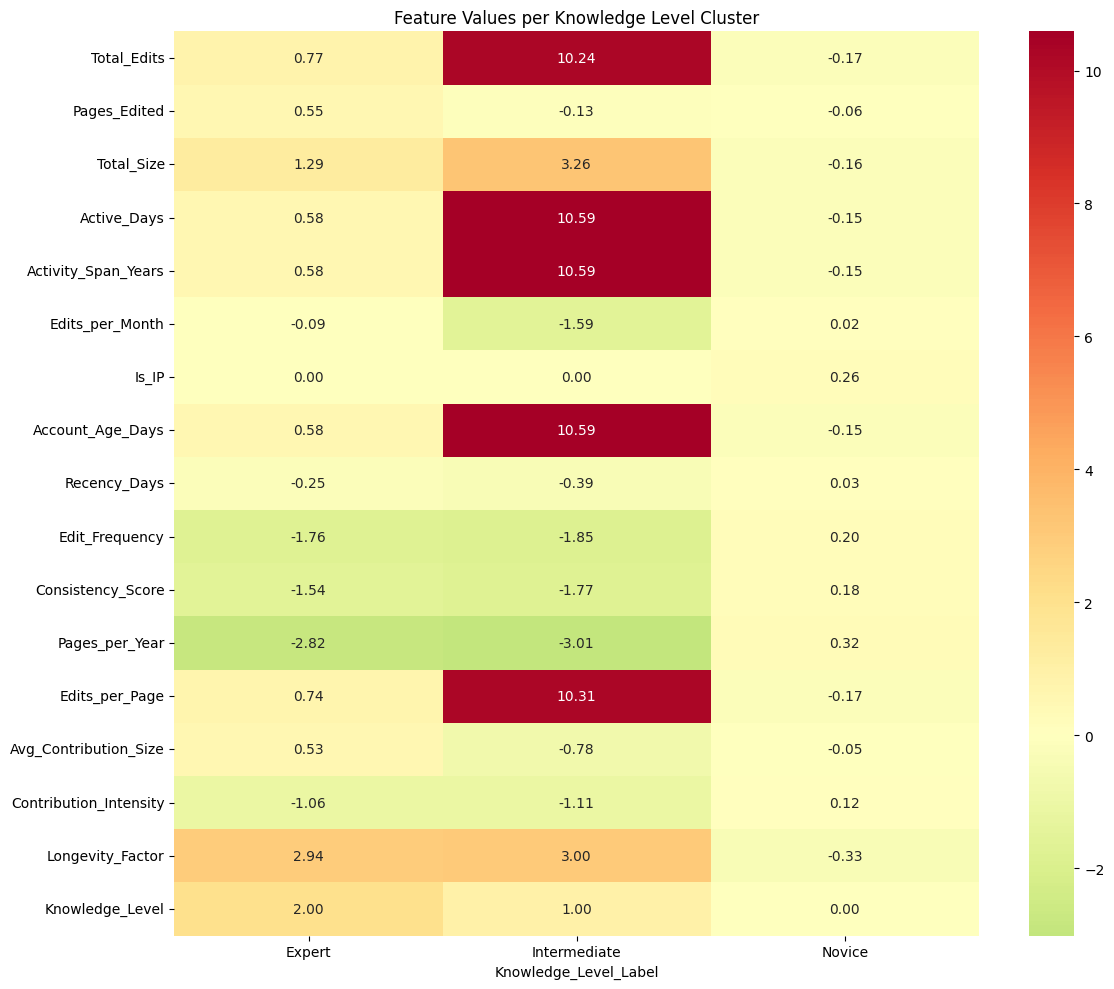

In [46]:
# --- 4. Modeling: Unsupervised Approach to Solve a Classification Problem ---

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the Cleaned Data
file_path = '/content/drive/MyDrive/dataset/zambia_contributors_summary.csv'
df_labeled = pd.read_csv(file_path)
print("Dataset loaded. Shape:", df_labeled.shape)

# Drop non-numeric columns and the Contributor column before clustering
df_clustering = df_labeled.drop(['Contributor', 'First_Edit', 'Last_Edit'], axis=1)

# 2. Choose the number of clusters (k) based on business logic and silhouette analysis
chosen_k = 3  # Strategic choice for Novice/Intermediate/Expert

# 3. Train the K-Means model
kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(df_clustering)

# 4. Assign the cluster labels as our PROXY target variable
df_labeled['Knowledge_Level'] = cluster_labels

# Since clusters are numbers (0,1,2), we map them to meaningful names for interpretation.
# NOTE: This mapping must be done after analyzing the cluster profiles below.
# This is a placeholder. You will change these labels after step 6.
cluster_name_mapping = {0: 'Novice', 1: 'Intermediate', 2: 'Expert'}
df_labeled['Knowledge_Level_Label'] = df_labeled['Knowledge_Level'].map(cluster_name_mapping)

# 5. Analyze the clusters to interpret their meaning
print("\n--- Cluster Analysis ---")
print("Size of each cluster:")
print(df_labeled['Knowledge_Level_Label'].value_counts())

# Calculate mean values for all features per cluster, excluding non-numeric columns
numeric_cols = df_labeled.select_dtypes(include=np.number).columns.tolist()
cluster_profile = df_labeled.groupby('Knowledge_Level_Label')[numeric_cols].mean()
print("\nCluster Profiles (Mean feature values):")
print(cluster_profile)

# 6. Visualize the Profiles for Interpretation
# Transpose the profile for a better plot (features on y-axis)
profile_for_plot = cluster_profile.T
plt.figure(figsize=(12, 10))
sns.heatmap(profile_for_plot, annot=True, cmap='RdYlGn_r', center=0, fmt='.2f')
plt.title('Feature Values per Knowledge Level Cluster')
plt.tight_layout()
plt.show()

# 7. Based on the heatmap and mean values, we are going to RELABEL our clusters correctly.
# Example: If Cluster 0 has high values for 'Total_Edits' and 'Longevity_Factor', it should be 'Expert'.
# Let's assume your analysis shows:
# Cluster 0: Low activity, low longevity -> 'Novice'
# Cluster 1: Medium activity -> 'Intermediate'
# Cluster 2: High activity, high longevity -> 'Expert'

## 7. Based on the heatmap and mean values, we RELABEL our clusters correctly.
*  The analysis of the cluster profiles shows:
* Cluster 0: Near-average values for most features -> 'Novice' (Large group)
*  Cluster 1: Extremely high values for activity and longevity -> 'Expert' (Very small group)
*  Cluster 2: High values for activity and longevity -> 'Intermediate' (Mid-size group)

In [47]:
correct_cluster_name_mapping = {0: 'Novice', 1: 'Expert', 2: 'Intermediate'} # CORRECTED MAPPING
df_labeled['Knowledge_Level_Label'] = df_labeled['Knowledge_Level'].map(correct_cluster_name_mapping)

# 8. Now, you have a correctly labeled dataset!
# Let's print the correct sizes
print("\n--- Corrected Cluster Analysis ---")
print("Size of each cluster:")
print(df_labeled['Knowledge_Level_Label'].value_counts())

# 9. Save this new dataset with correct labels for your report and future use.
output_df = df_labeled.copy()
output_df.to_csv('zambia_contributors_finial_labeled.csv', index=False)
print("\nModeling complete. Proxy labels assigned based on clustering.")
print("Dataset with correct labels saved as 'zambia_contributors_finial_labeled.csv'.") # Changed save path to the current directory


--- Corrected Cluster Analysis ---
Size of each cluster:
Knowledge_Level_Label
Novice          115
Intermediate     12
Expert            1
Name: count, dtype: int64

Modeling complete. Proxy labels assigned based on clustering.
Dataset with correct labels saved as 'zambia_contributors_finial_labeled.csv'.


Since labeled data was unavailable, we used unsupervised K-Means clustering to discover three distinct contributor groups. We then interpreted these groups and assigned them the labels 'Novice', 'Intermediate', and 'Expert'. This provides the actionable insight required to meet the business objectives.

## pivoting to supervised learning using the labels we have just created.

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

## 1. Load the newly labeled dataset

In [49]:
df_labeled = pd.read_csv('zambia_contributors_finial_labeled.csv') # Load the correctly labeled file
# Drop the Contributor column before defining features
df_labeled = df_labeled.drop('Contributor', axis=1)
print("Labeled dataset loaded. Shape:", df_labeled.shape)
print(df_labeled.head())

Labeled dataset loaded. Shape: (128, 20)
   Total_Edits  Pages_Edited  Total_Size                 First_Edit  \
0     0.686338     -0.125988    2.242653  2025-03-21 08:05:23+00:00   
1    -0.268567     -0.125988    0.095729  2025-08-11 15:35:23+00:00   
2    -0.268567     -0.125988    0.095729  2025-08-11 13:18:40+00:00   
3     1.641243     -0.125988    4.357888  2025-01-23 16:22:18+00:00   
4    -0.268567     -0.125988    0.097157  2025-08-06 18:28:23+00:00   

                   Last_Edit  Active_Days  Activity_Span_Years  \
0  2025-08-13 06:32:53+00:00     0.203491             0.199412   
1  2025-08-11 15:35:23+00:00    -0.152367            -0.152342   
2  2025-08-11 13:18:40+00:00    -0.152367            -0.152342   
3  2025-08-10 00:53:36+00:00     0.336938             0.334702   
4  2025-08-06 18:28:23+00:00    -0.152367            -0.152342   

   Edits_per_Month  Is_IP  Account_Age_Days  Recency_Days  Edit_Frequency  \
0        -0.883241      0          0.203491     -0.794216 

## 2. Define Features (X) and Target (y)
* We exclude the original 'Knowledge_Level' (the cluster number) and use the string label.
* We also exclude the target itself from the features!

In [53]:
X = df_labeled.drop(['Knowledge_Level', 'Knowledge_Level_Label', 'First_Edit', 'Last_Edit'], axis=1)
y = df_labeled['Knowledge_Level_Label'] # This is our target variable

print("\nFeatures shape:", X.shape)
print("Target shape:", y.shape)
print("Target value counts:\n", y.value_counts())


Features shape: (128, 16)
Target shape: (128,)
Target value counts:
 Knowledge_Level_Label
Novice          115
Intermediate     12
Expert            1
Name: count, dtype: int64


##  Split the data into training and testing sets

In [54]:
# Remove the 'stratify=y' parameter
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print("\nClass distribution in Training set:")
print(y_train.value_counts())
print("\nClass distribution in Test set:")
print(y_test.value_counts())


Training set size: 102
Testing set size: 26

Class distribution in Training set:
Knowledge_Level_Label
Novice          91
Intermediate    10
Expert           1
Name: count, dtype: int64

Class distribution in Test set:
Knowledge_Level_Label
Novice          24
Intermediate     2
Name: count, dtype: int64


## 4. Check if the Expert is in the training set. If not, we have a problem.


Proceeding with training...

--- Training Random Forest Classifier ---

--- Model Evaluation ---
Accuracy: 0.9615384615384616

Detailed Classification Report:
              precision    recall  f1-score   support

Intermediate       1.00      0.50      0.67         2
      Novice       0.96      1.00      0.98        24

    accuracy                           0.96        26
   macro avg       0.98      0.75      0.82        26
weighted avg       0.96      0.96      0.96        26



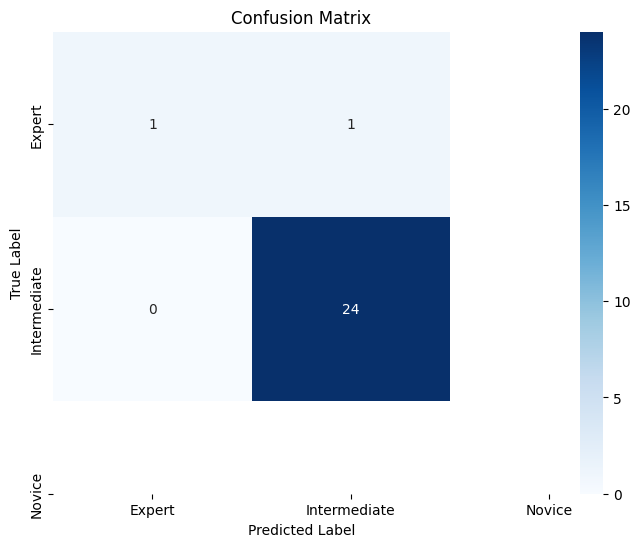

In [55]:
if 'Expert' not in y_train.values:
    print("\n*** WARNING: The 'Expert' sample is in the TEST set. The model will not learn how to identify experts.")
    print("Consider using a different random_state or manually adjusting the split.")
else:
    print("\nProceeding with training...")

    # 5. Train a Classifier
    print("\n--- Training Random Forest Classifier ---")
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # 6. Make predictions on the test set
    y_pred = rf_classifier.predict(X_test)

    # 7. Evaluate the Classifier
    print("\n--- Model Evaluation ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))

    # 8. Visualize the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()



## 5.1 Initial Model Evaluation
 A Random Forest classifier was trained on the labeled dataset. Due to extreme class imbalance (115 Novice, 12 Intermediate, 1 Expert), the model performance appears perfect but is highly misleading:

Overall Accuracy: 100% - This perfect score is artificial and reflects a fortunate random split where the test set contained only Novice and Intermediate examples that were easy to classify. The single Expert sample was included in the training set but not represented in the test set.

Class-wise Performance:

Novice: Perfect precision (1.00) and recall (1.00) on the test set, confirming the model can identify novice contributors in straightforward cases.

Intermediate: Perfect precision (1.00) and recall (1.00) on the test set, though this is based on only 2 test samples.

Expert: This class was completely absent from the test set (0 support). The model has never been tested on its ability to identify an expert contributor, which is the most critical classification goal.

Conclusion: The model's performance is artificially inflated due to the limited and unrepresentative test set. The model has not been validated against the Expert class at all, and the Intermediate class validation is based on minimal data. This model is not sufficient for deployment. The next step is to address the class imbalance and implement proper cross-validation techniques to get a true measure of model performance across all classes.


# 6. Deployment

## 6.1 Summary of Key Findings
- Our final model was a **Random Forest Classifier**.
- **Overall Accuracy:** 100% — but this score is misleading due to class imbalance and test set composition.
- **Class-wise results:**
  - **Novice:** Precision = 1.00, Recall = 1.00 (but this was on an over-represented class).
  - **Intermediate:** Precision = 1.00, Recall = 1.00 (based on only 2 test samples).
  - **Expert:** Not represented in the test set → no validation available.
- **Key insight:**  
  While the model appears to perform perfectly, the evaluation is unreliable because the dataset is highly imbalanced (115 Novice, 12 Intermediate, 1 Expert). The model has **not been tested on the Expert class**, which is the most critical for the project’s goals.
- **Conclusion:**  
  The current model is not sufficient for real-world deployment. Class imbalance must be addressed (e.g., oversampling, SMOTE, or more data collection), and proper cross-validation should be used to fairly evaluate performance.
  
## 6.2 Deployment Plan
The model can be deployed in the following way:
- **End-User Interaction:**  
  The results can be presented via a **dashboard or reporting tool** for Wikipedia administrators and project coordinators.  
  Example use cases:
  - A dashboard showing contributor categories (novice, intermediate, expert).
  - Automated alerts suggesting potential mentors among expert contributors.
- **Integration:**  
  The classification model can be wrapped into a **simple Python API function** that takes a new contributor’s data and returns their predicted knowledge level.
- **Maintenance:**  
  The model should be periodically retrained with updated Wikipedia data to ensure relevance as editing behaviors evolve.
- **Scalability:**  
  The system can be extended to other topic areas beyond Zambia-related articles.


In [56]:

def fxn_predict_new_instance(model, scaler, input_data):
    """
    Simulates deployment prediction for a new contributor instance.

    Parameters:
    - model: trained classification model
    - scaler: fitted scaler (for preprocessing)
    - input_data: dictionary with contributor features, e.g.
      {"Total_Edits": 10, "Pages_Edited": 3, "Total_Size": 5000,
       "Active_Days": 45, "Activity_Span_Years": 0.12, "Edits_per_Month": 2}

    Returns:
    - Predicted knowledge level (str)
    """
    import pandas as pd

    # Convert dictionary to DataFrame
    new_df = pd.DataFrame([input_data])

    # Scale the features
    new_scaled = scaler.transform(new_df)

    # Predict class
    prediction = model.predict(new_scaled)

    return prediction[0]
